[sine] Epoch 500/2000 | Loss_D: 0.8081 | Loss_G: 1.5421


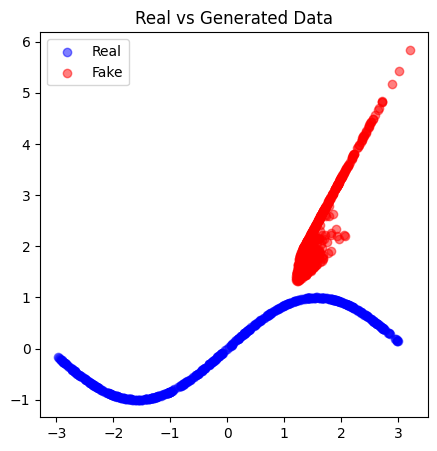

[sine] Epoch 1000/2000 | Loss_D: 1.6576 | Loss_G: 0.7236


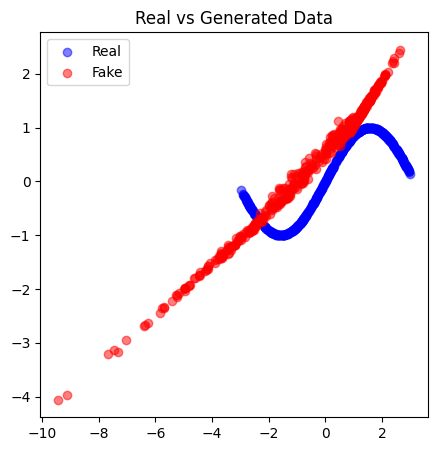

[sine] Epoch 1500/2000 | Loss_D: 1.3727 | Loss_G: 0.7334


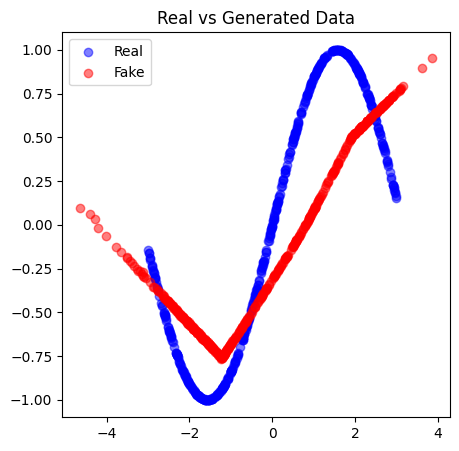

[sine] Epoch 2000/2000 | Loss_D: 1.3993 | Loss_G: 0.6816


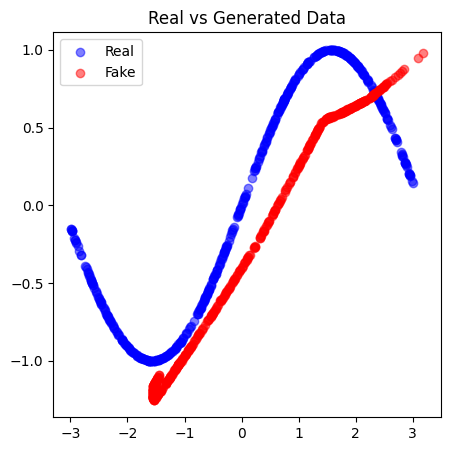

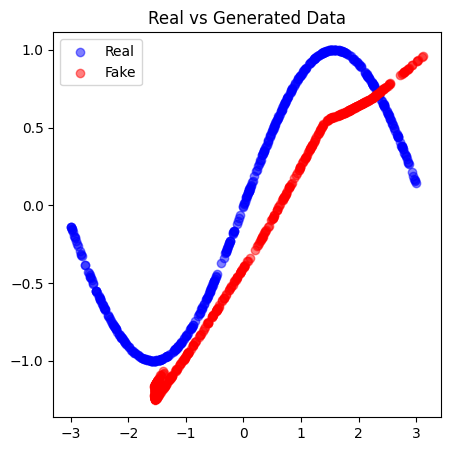

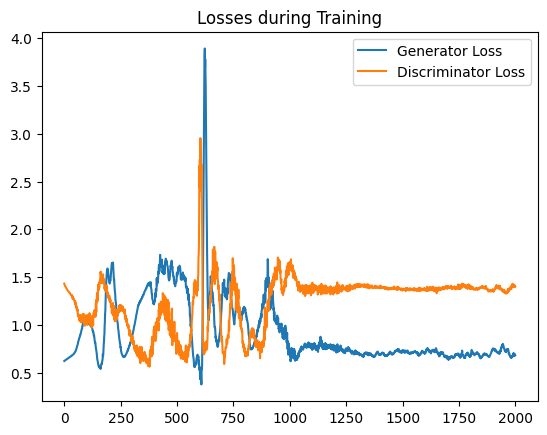

Saved plots for sine GAN.
[parametric] Epoch 500/2500 | Loss_D: 1.1487 | Loss_G: 0.8447


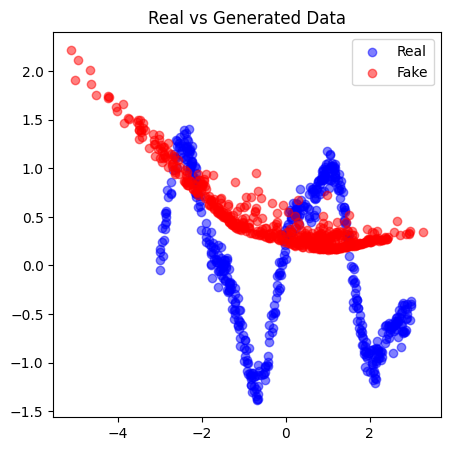

[parametric] Epoch 1000/2500 | Loss_D: 1.5292 | Loss_G: 0.6291


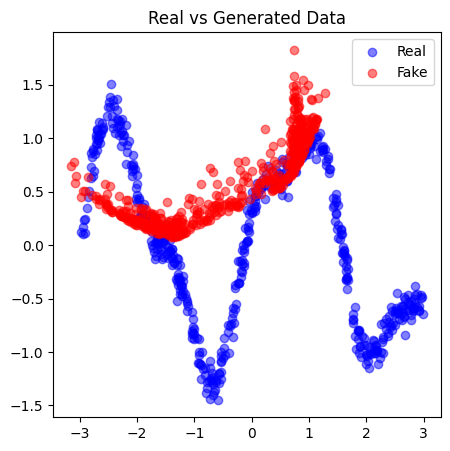

[parametric] Epoch 1500/2500 | Loss_D: 1.1589 | Loss_G: 0.8487


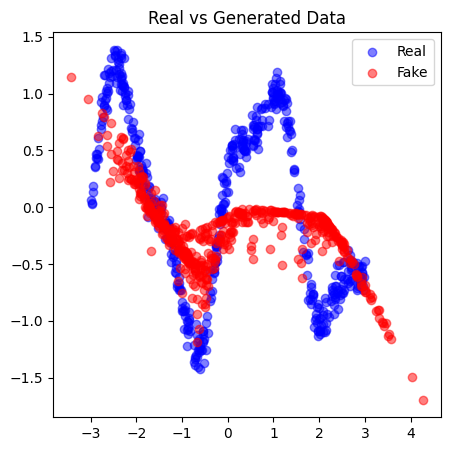

[parametric] Epoch 2000/2500 | Loss_D: 1.2917 | Loss_G: 0.6710


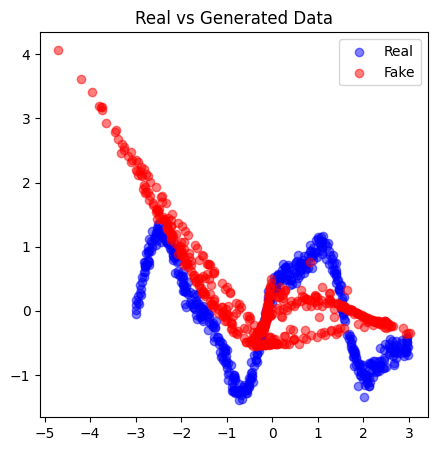

[parametric] Epoch 2500/2500 | Loss_D: 1.3763 | Loss_G: 0.7107


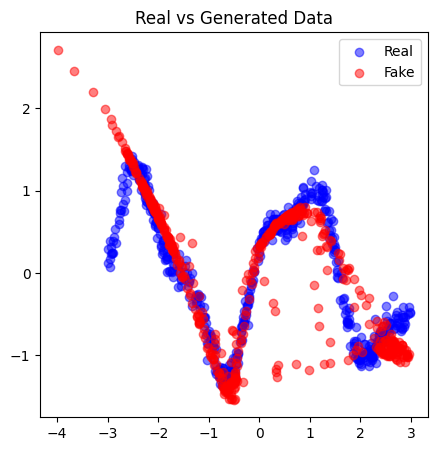

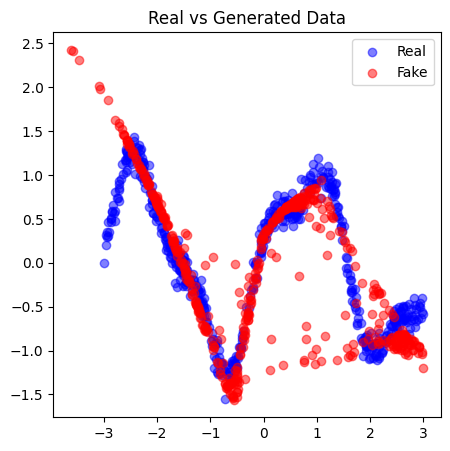

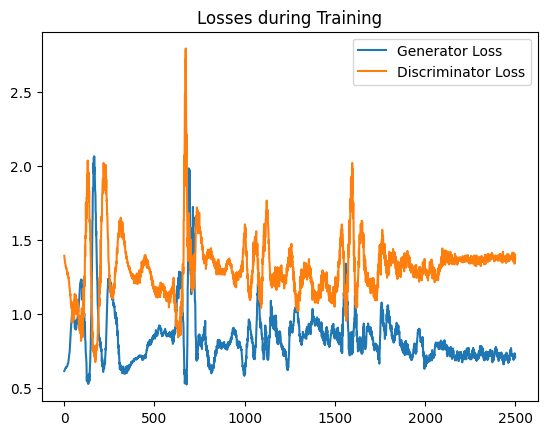

Saved plots for parametric GAN.


In [2]:
# Importing necessary libraries
import torch                          # Main PyTorch library
import torch.nn as nn                 # Neural network module from PyTorch
import numpy as np                   # Numerical operations
import matplotlib.pyplot as plt      # Plotting library

# For reproducibility: ensures consistent results each time you run
torch.manual_seed(42)
np.random.seed(42)

# Set device: use GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =======================================
# 1. DATA GENERATION FUNCTIONS
# =======================================

# Function to generate simple sine wave data
def generate_sine_wave_data(n_samples=512):
    x = np.random.uniform(-3, 3, n_samples)    # Random x values between -3 and 3
    y = np.sin(x)                              # Compute sine of x
    data = np.stack([x, y], 1)                 # Combine x and y into 2D points
    return data

# Function to generate more complex curve data (parametric)
def generate_parametric_curve(n_samples=512):
    x = np.random.uniform(-3, 3, n_samples)                            # Random x values
    y = np.sin(2 * x) + 0.3 * np.cos(5 * x) + np.random.normal(0, 0.1, n_samples)  # Combination of sine, cosine, and noise
    data = np.stack([x, y], 1)                                         # Combine into 2D points
    return data

# =======================================
# 2. GAN ARCHITECTURE
# =======================================

# Generator network: maps latent noise (z) to fake data
class Generator(nn.Module):
    def __init__(self, latent_dim=2, out_dim=2, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),  # Input layer
            nn.ReLU(),                          # Activation
            nn.Linear(hidden_dim, hidden_dim),  # Hidden layer
            nn.ReLU(),                          # Activation
            nn.Linear(hidden_dim, out_dim)      # Output layer
        )

    def forward(self, z):                        # Forward pass
        return self.net(z)

# Discriminator network: classifies real vs fake data
class Discriminator(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),      # Input layer
            nn.ReLU(),                          # Activation
            nn.Linear(hidden_dim, hidden_dim),  # Hidden layer
            nn.ReLU(),                          # Activation
            nn.Linear(hidden_dim, 1),           # Output: single value (real/fake)
            nn.Sigmoid()                        # Output between 0 and 1
        )

    def forward(self, x):                        # Forward pass
        return self.net(x)

# =======================================
# 3. TRAINING FUNCTION
# =======================================

# Training loop for the GAN
def train_gan(
    real_data_fn,      # Function to generate real data
    n_epochs=2000,     # Total number of training epochs
    latent_dim=2,      # Dimensionality of noise input to Generator
    batch_size=128,    # Number of samples per batch
    g_hidden=16,       # Generator hidden layer size
    d_hidden=16,       # Discriminator hidden layer size
    plot_every=500,    # Frequency of plotting results
    out_prefix="sine"  # Prefix for output file names
):
    # Initialize Generator and Discriminator models
    generator = Generator(latent_dim, 2, g_hidden).to(device)
    discriminator = Discriminator(2, d_hidden).to(device)

    # Binary Cross-Entropy loss for real/fake classification
    criterion = nn.BCELoss()

    # Optimizers for both networks
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.002)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.002)

    # Lists to store losses for visualization
    losses_g, losses_d = [], []

    # ======= Training Loop =======
    for epoch in range(1, n_epochs + 1):
        # === Train Discriminator ===

        # Sample real data
        real = torch.tensor(real_data_fn(batch_size), dtype=torch.float32).to(device)

        # Generate fake data from random noise
        z = torch.randn(batch_size, latent_dim).to(device)
        fake = generator(z).detach()  # Detach so we don’t backprop through generator

        # Create labels for real and fake data
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator predictions
        pred_real = discriminator(real)
        pred_fake = discriminator(fake)

        # Discriminator loss on real and fake
        loss_d = criterion(pred_real, real_labels) + criterion(pred_fake, fake_labels)

        # Backprop and update discriminator
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # === Train Generator ===

        # Generate fake data again
        z = torch.randn(batch_size, latent_dim).to(device)
        fake = generator(z)

        # Try to fool the discriminator
        pred_fake = discriminator(fake)

        # Generator loss: want discriminator to think fake is real
        loss_g = criterion(pred_fake, real_labels)

        # Backprop and update generator
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # Store current losses
        losses_g.append(loss_g.item())
        losses_d.append(loss_d.item())

        # Print and plot every few epochs
        if epoch % plot_every == 0 or epoch == n_epochs:
            print(f"[{out_prefix}] Epoch {epoch}/{n_epochs} | Loss_D: {loss_d.item():.4f} | Loss_G: {loss_g.item():.4f}")
            plot_generated_data(generator, real_data_fn, latent_dim, f"{out_prefix}_epoch{epoch}.png")

    # Final data visualization
    plot_generated_data(generator, real_data_fn, latent_dim, f"{out_prefix}_final.png")

    # Plot loss curves
    plt.figure()
    plt.plot(losses_g, label='Generator Loss')
    plt.plot(losses_d, label='Discriminator Loss')
    plt.legend()
    plt.title('Losses during Training')
    plt.savefig(f"{out_prefix}_losses.png")
    plt.show()
    plt.close()

    print(f"Saved plots for {out_prefix} GAN.")

# =======================================
# 4. PLOTTING FUNCTION
# =======================================

# Function to visualize generated vs real data
def plot_generated_data(generator, real_data_fn, latent_dim, out_file):
    generator.eval()  # Evaluation mode disables dropout, etc.
    with torch.no_grad():  # No gradient calculation for inference
        real_data = real_data_fn(512)                        # Real data
        z = torch.randn(512, latent_dim).to(device)          # Random noise
        fake_data = generator(z).cpu().numpy()               # Generated fake data

    # Create scatter plot
    plt.figure(figsize=(5,5))
    plt.scatter(real_data[:,0], real_data[:,1], c='blue', alpha=0.5, label='Real')
    plt.scatter(fake_data[:,0], fake_data[:,1], c='red', alpha=0.5, label='Fake')
    plt.legend()
    plt.title('Real vs Generated Data')
    plt.savefig(out_file)     # Save plot to file
    plt.show()                # Display plot
    plt.close()
    generator.train()         # Switch back to training mode

# =======================================
# 5. MAIN EXECUTION
# =======================================

# Run only if this file is executed as the main script
if __name__ == "__main__":
    # Train GAN on simple sine-wave data
    train_gan(
        real_data_fn=generate_sine_wave_data,
        n_epochs=2000,
        latent_dim=2,
        g_hidden=16,
        d_hidden=16,
        out_prefix="sine"
    )

    # Train GAN on more complex parametric data (larger network)
    train_gan(
        real_data_fn=generate_parametric_curve,
        n_epochs=2500,
        latent_dim=2,
        g_hidden=32,
        d_hidden=32,
        out_prefix="parametric"
    )
